# Importación de librerias necesarias

In [1]:
import os
import random

import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import cv2
from matplotlib import pyplot as plt
import imghdr

In [2]:
### Avoid OOM Errors
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Remover imagenes no útiles
Asegurarse que todas las imagenes tengan el formato adecuado

In [3]:
DATA_DIR = os.path.abspath('data')
DATA_DIR

'C:\\Users\\Fran\\git\\vetlens-ml\\data'

In [5]:
IMAGE_EXTS = ['jpeg', 'jpg', 'bmp', 'png']
for image_class in os.listdir(DATA_DIR):
    for image in os.listdir(os.path.join(DATA_DIR, image_class)):
        image_path = os.path.join(DATA_DIR, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)

            if tip not in IMAGE_EXTS:
                print(f'Image has ext: {tip} not in ext list {image_path}')
                #os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

# Visualización de los datos con los que se está trabajando

In [6]:
class_names = []
img_count = np.array([])
for class_name in os.listdir(os.path.join(DATA_DIR)):
    count = len(os.listdir(os.path.join(DATA_DIR, class_name)))
    class_names.append(class_name)
    img_count = np.append(img_count, count)
class_names,img_count

(['dermatitis_piotraumatica',
  'dermatofitosis',
  'miasis',
  'otra_enfermedad',
  'sin_problemas'],
 array([ 946.,  988.,  879.,  920., 1012.]))

In [7]:
print(f'Mediana de imagenes por clase: {np.median(img_count)}')

Mediana de imagenes por clase: 946.0


Comprobamos que el dataset esta balanceado:

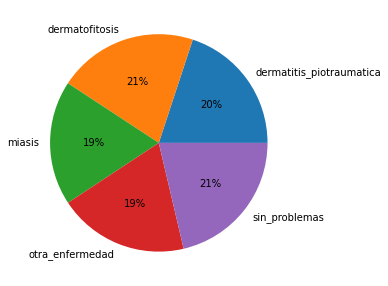

In [8]:
fig = plt.figure(figsize=(5,5))
pie = plt.pie(img_count, labels=class_names, autopct= lambda x: '{:.0f}%'.format(x))
plt.show()

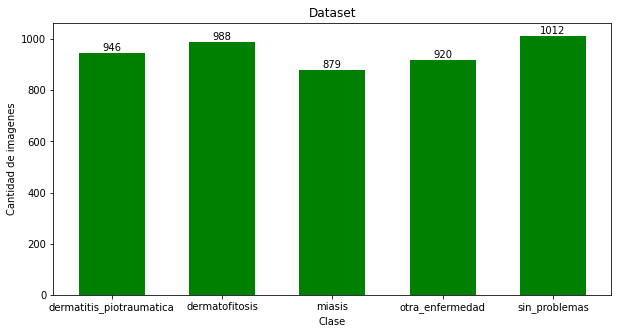

In [9]:
fig = plt.figure(figsize= (10,5))
bars = plt.bar(class_names, img_count, color='green', width=.6)
plt.bar_label(bars)
plt.ylabel('Cantidad de imagenes')
plt.xlabel('Clase')
plt.title('Dataset')
plt.show()

# Aumento de Datos
Dado que el dataset inicial es bastante pequeño, realizaremos operaciones de aumento de datos. De esta forma, se aumenta la cantidad de datos para entrenamiento, prueba y validación y también se disminuye la probabilidad de overfitting.

Primero definimos las transformaciones:

In [9]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    zoom_range=.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=0
)

In [10]:
def augment (x, dir, prefix):
    i = 0
    for batch in datagen.flow(x, batch_size=32, save_to_dir=dir, save_prefix=prefix, save_format='jpeg'):
        i +=1
        if i > 20: # paramos la cantidad de transformaciones para evitar que sean infinitas
            break

In [10]:
def process_image(image_path, img_size=224):

  """
  Toma la ruta de una imagen y la devuelve como un Tensor
  """

  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, size=[img_size, img_size])

  return image

In [12]:
derm_dir = [os.path.abspath(os.path.join('data','dermatofitosis', fname)) for fname in os.listdir(os.path.abspath(os.path.join('data','dermatofitosis')))]
pio_dir = [os.path.abspath(os.path.join('data','dermatitis_piotraumatica', fname)) for fname in os.listdir(os.path.abspath(os.path.join('data','dermatitis_piotraumatica')))]
mia_dir = [os.path.abspath(os.path.join('data','miasis', fname)) for fname in os.listdir(os.path.abspath(os.path.join('data','miasis')))]
sin_prob_dir = [os.path.abspath(os.path.join('data','sin_problemas', fname)) for fname in os.listdir(os.path.abspath(os.path.join('data','sin_problemas')))]
otras_dir = [os.path.abspath(os.path.join('data','otra_enfermedad', fname)) for fname in os.listdir(os.path.abspath(os.path.join('data','otra_enfermedad')))]

In [13]:
derm = tf.data.Dataset.from_tensor_slices(tf.constant(derm_dir))
derm_batch = derm.map(process_image).batch(32)
pio = tf.data.Dataset.from_tensor_slices(tf.constant(pio_dir))
pio_batch = pio.map(process_image).batch(32)
mia = tf.data.Dataset.from_tensor_slices(tf.constant(mia_dir))
mia_batch = mia.map(process_image).batch(32)
sin_prob = tf.data.Dataset.from_tensor_slices(tf.constant(sin_prob_dir))
sin_prob_batch = sin_prob.map(process_image).batch(32)
otra = tf.data.Dataset.from_tensor_slices(tf.constant(otras_dir))
otra_batch = otra.map(process_image).batch(32)

derm_batch, pio_batch, mia_batch

(<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>,
 <BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>,
 <BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>)

In [ ]:
for img in derm_batch.as_numpy_iterator():
    augment(img, 'data\\dermatofitosis', 'dermatofitosis')
for img in pio_batch.as_numpy_iterator():
    augment(img, 'data\\dermatitis_piotraumatica', 'piotraumatica')
for img in mia_batch.as_numpy_iterator():
    augment(img, 'data\\miasis', 'miasis')
for img in sin_prob_batch.as_numpy_iterator():
    augment(img, 'data\\sin_problemas', 'sin_problemas')
for img in otra_batch.as_numpy_iterator():
    augment(img, 'data\\otra_enfermedad', 'otra_enfermedad')

# Comenzamos a trabajar con los datos

In [4]:
IMAGE_SIZE = 224
INPUT_SHAPE = (None, IMAGE_SIZE, IMAGE_SIZE, 3)
SEED = random.randint(0,10000000)
SEED

4141751

In [5]:
training_dataset, validation_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    label_mode='categorical',
    color_mode='rgb',
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32,
    shuffle=True,
    seed=SEED,
    validation_split=.2,
    subset='both',
    interpolation='bicubic')

Found 4745 files belonging to 5 classes.
Using 3796 files for training.
Using 949 files for validation.


In [6]:
training_dataset, validation_dataset

(<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>)

In [7]:
diseases = training_dataset.class_names

In [8]:
batch_train = training_dataset.as_numpy_iterator().next()
batch_val = validation_dataset.as_numpy_iterator().next()

In [9]:
def print_first_10(batch, has_labels=True):
    """
    Imprime las primeras 10 imagenes de un batch de imagenes, y si poseen labels, las labels respectivas
    :param batch: a batch of images
    :return: None
    """
    fig, ax = plt.subplots(ncols=10, figsize=(20,20))
    for idx, img in enumerate(batch[0][:10]):
        ax[idx].imshow(img.astype(int))
        if has_labels:
            ax[idx].title.set_text(diseases[np.argmax(batch[1][idx])])

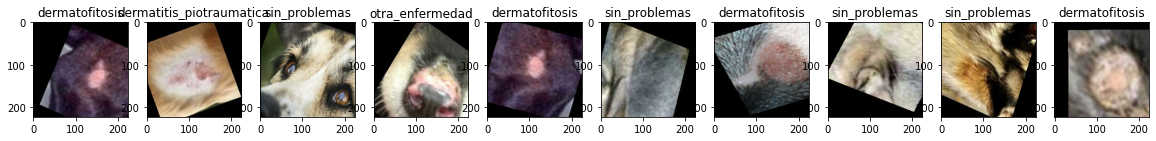

In [10]:
print_first_10(batch_train)

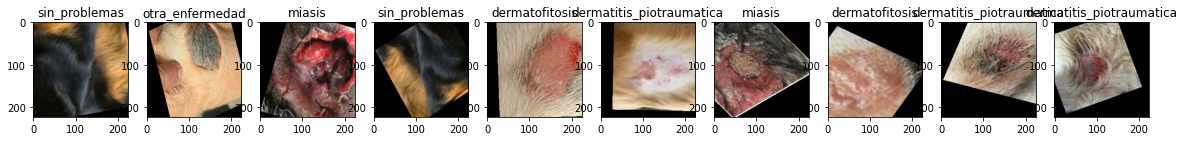

In [11]:
print_first_10(batch_val)

Debemos normalizar las imágenes, es decir, transformar los valores de los pixeles que van de 0 - 255, para que vayan de 0 - 1:

In [19]:

#training_dataset = training_dataset.map(lambda x, y: (x/255, y))
#validation_dataset = validation_dataset.map(lambda x, y: (x/255, y))
#training_dataset, validation_dataset

(<MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>,
 <MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>)

# Pruebas con diferentes modelos base

Dado que estaremos utilizando transfer learning, tenemos que encontrar que modelo tiene un mejor rendimiento para el problema que intentamos resolver. Para ello se probarán los siguientes modelos: ResNet50, Xception, VGG16 y EfficientNetB2. Puesto que estos modelos tienen una alta complejidad, no se quiere agregar demasiadas capas, puesto que esto podría transformarse un detrimento para el rendimiento.

Cada modelo tiene diferentes requerimientos para sus inputs, por ende lo primero será ajustarse a ello.


## Rendimiento ResNet50

In [13]:
resnet_train_ds = training_dataset.map(lambda x,y: (tf.keras.applications.resnet.preprocess_input(x), y))
resnet_vald_ds = validation_dataset.map(lambda x,y: (tf.keras.applications.resnet.preprocess_input(x), y))

In [20]:
base_model = tf.keras.applications.ResNet50(include_top=False,
                                            weights='imagenet',
                                            input_shape=(224, 224 ,3))
base_model.trainable = False

model_resnet = tf.keras.Sequential()

model_resnet.add(base_model)

model_resnet.add(tf.keras.layers.Flatten())
model_resnet.add(tf.keras.layers.Dense(5, activation='softmax'))


In [21]:
model_resnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 5)                 501765    
                                                                 
Total params: 21,363,245
Trainable params: 501,765
Non-trainable params: 20,861,480
_________________________________________________________________


In [22]:
model_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [23]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

## Entrenamiento modelo ResNet

Definimos early_stopping para evitar que el modelo haga overfitting:

In [24]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [ ]:
hist_resnet = model_resnet.fit(training_dataset, epochs=30, validation_data=validation_dataset, callbacks=[tensorboard_callback, early_stopping])

Epoch 1/15
119/119 [==============================] - 22s 162ms/step - loss: 1.2336 - accuracy: 0.5068 - val_loss: 0.9581 - val_accuracy: 0.6586
Epoch 2/15
119/119 [==============================] - 19s 155ms/step - loss: 0.7872 - accuracy: 0.7371 - val_loss: 0.7534 - val_accuracy: 0.7450
Epoch 3/15
119/119 [==============================] - 19s 156ms/step - loss: 0.6116 - accuracy: 0.8143 - val_loss: 0.6436 - val_accuracy: 0.7850
Epoch 4/15
119/119 [==============================] - 19s 157ms/step - loss: 0.5007 - accuracy: 0.8656 - val_loss: 0.5705 - val_accuracy: 0.8145
Epoch 5/15
119/119 [==============================] - 19s 158ms/step - loss: 0.4239 - accuracy: 0.8959 - val_loss: 0.5123 - val_accuracy: 0.8356
Epoch 6/15
119/119 [==============================] - 19s 160ms/step - loss: 0.3663 - accuracy: 0.9170 - val_loss: 0.4698 - val_accuracy: 0.8546
Epoch 7/15
119/119 [==============================] - 19s 162ms/step - loss: 0.3206 - accuracy: 0.9378 - val_loss: 0.4421 - val_ac

## Métricas del modelo ResNet

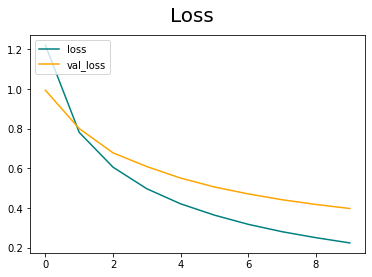

In [25]:
fig = plt.figure()
plt.plot(hist_resnet.history['loss'], color='teal', label='loss')
plt.plot(hist_resnet.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

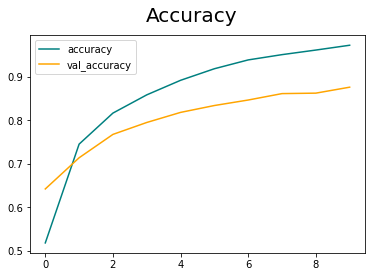

In [26]:
fig = plt.figure()
plt.plot(hist_resnet.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_resnet.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

## Rendimiento Xception

In [ ]:
xception_train_ds = training_dataset.map(lambda x,y: (tf.keras.applications.xception.preprocess_input(x), y))
xception_vald_ds = validation_dataset.map(lambda x,y: (tf.keras.applications.xception.preprocess_input(x), y))

In [20]:
base_model = tf.keras.applications.Xception(include_top=False,
                                            weights='imagenet',
                                            input_shape=(224, 224 ,3))
base_model.trainable = False

model_xception = tf.keras.Sequential()

model_xception.add(base_model)

model_xception.add(tf.keras.layers.Flatten())
model_xception.add(tf.keras.layers.Dense(5, activation='softmax'))


In [21]:
model_xception.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 5)                 501765    
                                                                 
Total params: 21,363,245
Trainable params: 501,765
Non-trainable params: 20,861,480
_________________________________________________________________


In [22]:
model_xception.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [23]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

## Entrenamiento modelo Xception

Definimos early_stopping para evitar que el modelo haga overfitting:

In [24]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [ ]:
hist_xception = model_xception.fit(training_dataset, epochs=30, validation_data=validation_dataset, callbacks=[tensorboard_callback, early_stopping])

Epoch 1/15
119/119 [==============================] - 22s 162ms/step - loss: 1.2336 - accuracy: 0.5068 - val_loss: 0.9581 - val_accuracy: 0.6586
Epoch 2/15
119/119 [==============================] - 19s 155ms/step - loss: 0.7872 - accuracy: 0.7371 - val_loss: 0.7534 - val_accuracy: 0.7450
Epoch 3/15
119/119 [==============================] - 19s 156ms/step - loss: 0.6116 - accuracy: 0.8143 - val_loss: 0.6436 - val_accuracy: 0.7850
Epoch 4/15
119/119 [==============================] - 19s 157ms/step - loss: 0.5007 - accuracy: 0.8656 - val_loss: 0.5705 - val_accuracy: 0.8145
Epoch 5/15
119/119 [==============================] - 19s 158ms/step - loss: 0.4239 - accuracy: 0.8959 - val_loss: 0.5123 - val_accuracy: 0.8356
Epoch 6/15
119/119 [==============================] - 19s 160ms/step - loss: 0.3663 - accuracy: 0.9170 - val_loss: 0.4698 - val_accuracy: 0.8546
Epoch 7/15
119/119 [==============================] - 19s 162ms/step - loss: 0.3206 - accuracy: 0.9378 - val_loss: 0.4421 - val_ac

## Métricas del modelo Xception

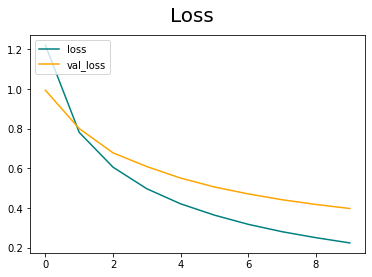

In [25]:
fig = plt.figure()
plt.plot(hist_xception.history['loss'], color='teal', label='loss')
plt.plot(hist_xception.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

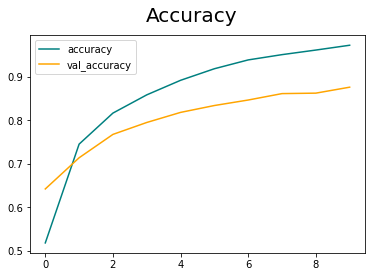

In [26]:
fig = plt.figure()
plt.plot(hist_xception.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_xception.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

## Rendimiento VGG16

In [ ]:
vgg16_train_ds = training_dataset.map(lambda x,y: (tf.keras.applications.vgg16.preprocess_input(x), y))
vgg16_vald_ds = validation_dataset.map(lambda x,y: (tf.keras.applications.vgg16.preprocess_input(x), y))

In [20]:
base_model = tf.keras.applications.VGG16(include_top=False,
                                            weights='imagenet',
                                            input_shape=(224, 224 ,3))
base_model.trainable = False

model_vgg16 = tf.keras.Sequential()

model_vgg16.add(base_model)

model_vgg16.add(tf.keras.layers.Flatten())
model_vgg16.add(tf.keras.layers.Dense(5, activation='softmax'))


In [21]:
model_vgg16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 5)                 501765    
                                                                 
Total params: 21,363,245
Trainable params: 501,765
Non-trainable params: 20,861,480
_________________________________________________________________


In [22]:
model_vgg16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [23]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

## Entrenamiento modelo VGG16

Definimos early_stopping para evitar que el modelo haga overfitting:

In [24]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [ ]:
hist_vgg16 = model_vgg16.fit(training_dataset, epochs=30, validation_data=validation_dataset, callbacks=[tensorboard_callback, early_stopping])

Epoch 1/15
119/119 [==============================] - 22s 162ms/step - loss: 1.2336 - accuracy: 0.5068 - val_loss: 0.9581 - val_accuracy: 0.6586
Epoch 2/15
119/119 [==============================] - 19s 155ms/step - loss: 0.7872 - accuracy: 0.7371 - val_loss: 0.7534 - val_accuracy: 0.7450
Epoch 3/15
119/119 [==============================] - 19s 156ms/step - loss: 0.6116 - accuracy: 0.8143 - val_loss: 0.6436 - val_accuracy: 0.7850
Epoch 4/15
119/119 [==============================] - 19s 157ms/step - loss: 0.5007 - accuracy: 0.8656 - val_loss: 0.5705 - val_accuracy: 0.8145
Epoch 5/15
119/119 [==============================] - 19s 158ms/step - loss: 0.4239 - accuracy: 0.8959 - val_loss: 0.5123 - val_accuracy: 0.8356
Epoch 6/15
119/119 [==============================] - 19s 160ms/step - loss: 0.3663 - accuracy: 0.9170 - val_loss: 0.4698 - val_accuracy: 0.8546
Epoch 7/15
119/119 [==============================] - 19s 162ms/step - loss: 0.3206 - accuracy: 0.9378 - val_loss: 0.4421 - val_ac

## Métricas del modelo VGG16

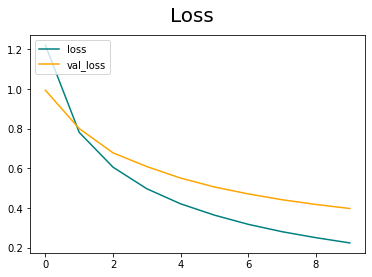

In [25]:
fig = plt.figure()
plt.plot(hist_vgg16.history['loss'], color='teal', label='loss')
plt.plot(hist_vgg16.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

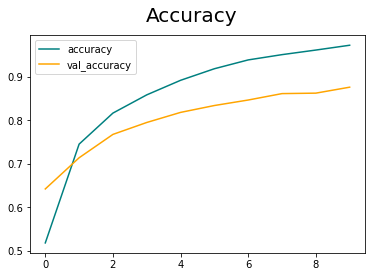

In [26]:
fig = plt.figure()
plt.plot(hist_vgg16.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_vgg16.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

## Rendimiento EfficientNetB2

In [20]:
base_model = tf.keras.applications.EfficientNetB2(include_top=False,
                                            weights='imagenet',
                                            input_shape=(224, 224 ,3))
base_model.trainable = False

model_efficientnetb2 = tf.keras.Sequential()

model_efficientnetb2.add(base_model)

model_efficientnetb2.add(tf.keras.layers.Flatten())
model_efficientnetb2.add(tf.keras.layers.Dense(5, activation='softmax'))


In [21]:
model_efficientnetb2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 5)                 501765    
                                                                 
Total params: 21,363,245
Trainable params: 501,765
Non-trainable params: 20,861,480
_________________________________________________________________


In [22]:
model_efficientnetb2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [23]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

## Entrenamiento modelo EfficientNetB2

Definimos early_stopping para evitar que el modelo haga overfitting:

In [24]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [ ]:
hist_efficientnetb2 = model_efficientnetb2.fit(training_dataset, epochs=30, validation_data=validation_dataset, callbacks=[tensorboard_callback, early_stopping])

Epoch 1/15
119/119 [==============================] - 22s 162ms/step - loss: 1.2336 - accuracy: 0.5068 - val_loss: 0.9581 - val_accuracy: 0.6586
Epoch 2/15
119/119 [==============================] - 19s 155ms/step - loss: 0.7872 - accuracy: 0.7371 - val_loss: 0.7534 - val_accuracy: 0.7450
Epoch 3/15
119/119 [==============================] - 19s 156ms/step - loss: 0.6116 - accuracy: 0.8143 - val_loss: 0.6436 - val_accuracy: 0.7850
Epoch 4/15
119/119 [==============================] - 19s 157ms/step - loss: 0.5007 - accuracy: 0.8656 - val_loss: 0.5705 - val_accuracy: 0.8145
Epoch 5/15
119/119 [==============================] - 19s 158ms/step - loss: 0.4239 - accuracy: 0.8959 - val_loss: 0.5123 - val_accuracy: 0.8356
Epoch 6/15
119/119 [==============================] - 19s 160ms/step - loss: 0.3663 - accuracy: 0.9170 - val_loss: 0.4698 - val_accuracy: 0.8546
Epoch 7/15
119/119 [==============================] - 19s 162ms/step - loss: 0.3206 - accuracy: 0.9378 - val_loss: 0.4421 - val_ac

## Métricas del modelo EfficientNetB2

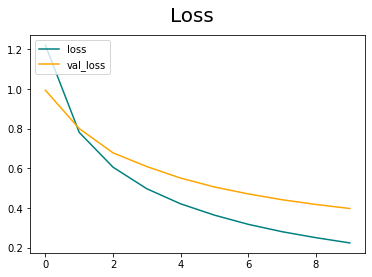

In [25]:
fig = plt.figure()
plt.plot(hist_efficientnetb2.history['loss'], color='teal', label='loss')
plt.plot(hist_efficientnetb2.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

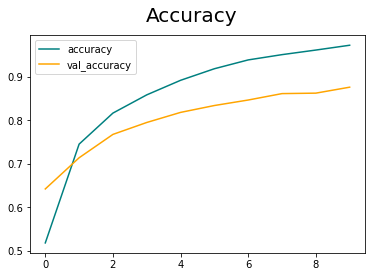

In [26]:
fig = plt.figure()
plt.plot(hist_efficientnetb2.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_efficientnetb2.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

# Predicciones

In [27]:
prediction_resnet = model_resnet.predict(validation_dataset)
prediction_xception = model_xception.predict(validation_dataset)
prediction_vgg16 = model_vgg16.predict(validation_dataset)
prediction_efficientnetb2 = model_efficientnetb2.predict(validation_dataset)

30/30 [==============================] - 5s 122ms/step


In [29]:
images = []
labels = []
for image, label in validation_dataset.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(diseases[np.argmax(label)])

(array([[[0.03921569, 0.        , 0.        ],
         [0.04313726, 0.        , 0.        ],
         [0.03921569, 0.        , 0.        ],
         ...,
         [0.        , 0.00784314, 0.        ],
         [0.        , 0.00392157, 0.        ],
         [0.        , 0.00784314, 0.        ]],
 
        [[0.03921569, 0.        , 0.        ],
         [0.04313726, 0.        , 0.        ],
         [0.03921569, 0.        , 0.        ],
         ...,
         [0.        , 0.00392157, 0.        ],
         [0.        , 0.00392157, 0.        ],
         [0.        , 0.00784314, 0.        ]],
 
        [[0.3647059 , 0.3137255 , 0.2784314 ],
         [0.36078432, 0.30980393, 0.27450982],
         [0.33333334, 0.28627452, 0.23921569],
         ...,
         [0.        , 0.00392157, 0.        ],
         [0.        , 0.00392157, 0.        ],
         [0.        , 0.00392157, 0.        ]],
 
        ...,
 
        [[0.16470589, 0.1254902 , 0.08627451],
         [0.1764706 , 0.13725491, 0.09803

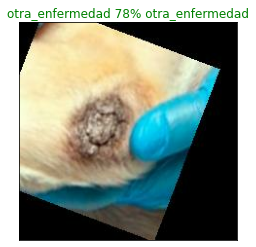

In [30]:
def plot_pred(prediction_probabilities, labels_p, images_p, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image_v = prediction_probabilities[n], labels_p[n], images_p[n]
  # Get the pred label
  pred_label = diseases[np.argmax(pred_prob)]

  # Plot image and remove ticks
  plt.imshow(image_v)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is right or wrong.

  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Change the plot title to be predicted label, probability of prediction and truth label.
  plt.title("{} {:2.0f}% {}".format(pred_label, np.max(pred_prob)*100, true_label), color=color)

In [ ]:
plot_pred(prediction_resnet, labels, images, n=5)

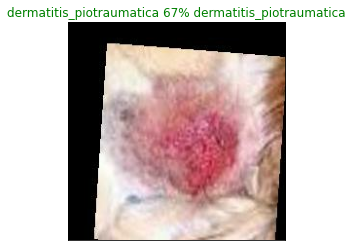

In [31]:
plot_pred(prediction_xception, labels, images, n=5)

In [ ]:
plot_pred(prediction_vgg16, labels, images, n=5)

In [ ]:
plot_pred(prediction_efficientnetb2, labels, image, n=5)

In [32]:
def plot_pred_conf(prediction_probabilities, labels_x, n=1):
  """
  Plot the top 10 highest prediction confidences along with the truth label for sample n
  """
  pred_prob, true_label = prediction_probabilities[n], labels_x[n]

  # Get the predicted label

  pred_label = diseases[np.argmax(pred_prob)]

  # Find the top 10 prediction confidence indexes

  top_3_pred_indexes = pred_prob.argsort()# En orden descendente
  # Find the top 10 prediction confidence values
  top_3_pred_values = pred_prob[top_3_pred_indexes]

  # Find the top 10 prediction labels

  top_3_pred_labels = np.array(diseases)[top_3_pred_indexes]

  # Setup plot

  top_plot = plt.bar(np.arange(len(top_3_pred_labels)), top_3_pred_values, color="grey")
  plt.xticks(np.arange(len(top_3_pred_labels)), labels=top_3_pred_labels, rotation="vertical")

  # Change color of the true label

  if np.isin(true_label, top_3_pred_indexes):
    top_plot[np.argmax(top_3_pred_indexes == true_label)].set_color("green")
  else:
    pass

C:\Users\Fran\.conda\envs\tf\lib\site-packages\numpy\lib\arraysetops.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


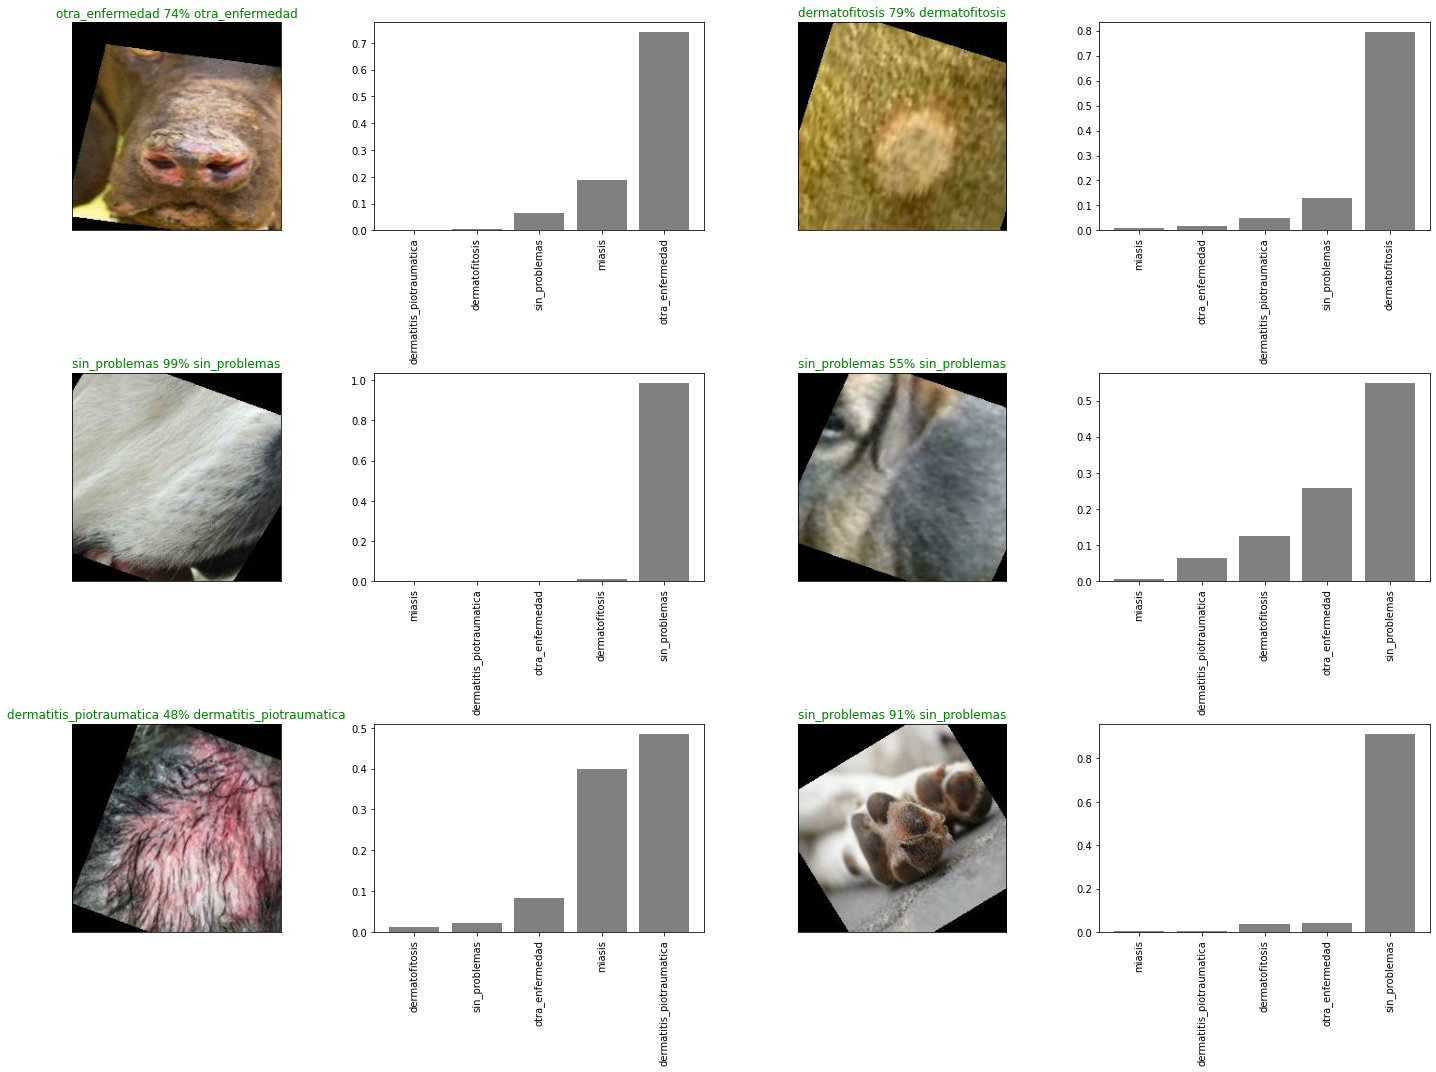

In [33]:
i_multiplier = 10
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range (num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=prediction_resnet, labels_p=labels, images_p=images, n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_resnet, labels, n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

In [ ]:
i_multiplier = 10
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range (num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=prediction_xception, labels_p=labels, images_p=images, n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_xception, labels, n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

In [ ]:
i_multiplier = 10
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range (num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=prediction_vgg16, labels_p=labels, images_p=images, n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_vgg16, labels, n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

In [ ]:
i_multiplier = 10
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range (num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=prediction_efficientnetb2, labels_p=labels, images_p=images, n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_efficientnetb2, labels, n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

In [34]:
def get_test_img_paths_with_labels(testing_dir='testing'):
    test_img_paths = []
    test_labels = []

    for folder_name in os.listdir(testing_dir):
        for file_name in os.listdir(os.path.join(testing_dir, folder_name)):
            test_img_paths.append(os.path.abspath(os.path.join(testing_dir, folder_name, file_name)))
            test_labels.append(folder_name)

    return test_img_paths, test_labels

In [35]:
def make_prediction(images_paths, model_to_use='trained'):
    dataset = tf.data.Dataset.from_tensor_slices(tf.constant(images_paths))
    dataset_batch = dataset.map(process_image).batch(32)
    if model_to_use == 'xception':
        ## 4 clases
        xception_model = tf.keras.models.load_model((os.path.join('models', 'dogsskindiseaseswithother_v1_xception.h5')))
        predictions = xception_model.predict(dataset_batch)
    elif model_to_use == 'vgg16':
        ## 3 clases
        vgg16_model = tf.keras.models.load_model((os.path.join('models', 'dogsskindiseaseswithother_v1.h5')))
        predictions = vgg16_model.predict(dataset_batch)
    elif model_to_use == 'trained':
        predictions = model.predict(dataset_batch)
    else:
        print('There is no such model!')
        return
    return predictions

In [36]:
def print_text_pred_5_classes(predictions, test_image_paths, test_lbls):
    accurate_pred = 0
    total_pred = len(test_image_paths)
    file_names = [fname.split('\\')[-1] for fname in test_image_paths]

    for idx, img in enumerate(file_names):
        pred_res = diseases[np.argmax(predictions[idx])]
        if pred_res == test_lbls[idx] or pred_res == 'sin_problemas' and test_lbls[idx] == 'otra_enfermedad' or pred_res == 'otra_enfermedad' and test_lbls[idx] == 'sin_problemas':
            accurate_pred += 1
        print(f'Prediction for image: {img} is \'{diseases[np.argmax(predictions[idx])]}\' with a {predictions[idx][np.argmax(predictions[idx])]*100:.2f}%. True class: {test_lbls[idx]}.\nResults: \'dermatofitosis\': {predictions[idx][1]*100:.2f}%, \'piotraumatica\': {predictions[idx][0]*100:.2f}%, \'miasis\': {predictions[idx][2]*100:.2f}%, \'otras\': {predictions[idx][3]*100:.2f}%, \'sano\': {predictions[idx][4]*100:.2f}%\n=====================================')
    print(f'Precision: {(accurate_pred/total_pred)*100}')

In [37]:
def print_text_pred_4_classes(predictions, test_image_paths, test_lbls):
    accurate_pred = 0
    total_pred = len(test_image_paths)
    file_names = [fname.split('\\')[-1] for fname in test_image_paths]

    for idx, img in enumerate(file_names):
        pred_res = diseases[np.argmax(predictions[idx])]
        if pred_res == test_lbls[idx] or pred_res == 'otra_enfermedad' and test_lbls[idx] == 'sin_problemas':
            accurate_pred += 1
        print(f'Prediction for image: {img} is \'{diseases[np.argmax(predictions[idx])]}\' with a {predictions[idx][np.argmax(predictions[idx])]*100:.2f}%. True class: {test_lbls[idx]}.\nResults: \'dermatofitosis\': {predictions[idx][1]*100:.2f}%, \'piotraumatica\': {predictions[idx][0]*100:.2f}%, \'miasis\': {predictions[idx][2]*100:.2f}%, \'otras\': {predictions[idx][3]*100:.2f}%\n=====================================')
    print(f'Precision: {(accurate_pred/total_pred)*100}')

In [40]:
test_img_paths, test_labels = get_test_img_paths_with_labels(testing_dir='testing')
predictions_xception = make_prediction(test_img_paths, model_to_use='xception')
predictions_trained = make_prediction(test_img_paths, model_to_use='trained')

2/2 [==============================] - 1s 120ms/step


In [41]:
print_text_pred_4_classes(predictions_xception, test_image_paths=test_img_paths, test_lbls=test_labels)
print_text_pred_5_classes(predictions_trained, test_image_paths=test_img_paths, test_lbls=test_labels)

Prediction for image: dermatitis piotraumatica_0.jpg is 'dermatitis_piotraumatica' with a 73.95%. True class: dermatitis_piotraumatica.
Results: 'dermatofitosis': 8.93%, 'piotraumatica': 73.95%, 'miasis': 0.35%, 'otras': 16.76%
Prediction for image: dermatitis piotraumatica_1.jpg is 'dermatofitosis' with a 65.84%. True class: dermatitis_piotraumatica.
Results: 'dermatofitosis': 65.84%, 'piotraumatica': 33.86%, 'miasis': 0.10%, 'otras': 0.20%
Prediction for image: dermatitis piotraumatica_2.jpg is 'dermatitis_piotraumatica' with a 85.28%. True class: dermatitis_piotraumatica.
Results: 'dermatofitosis': 14.69%, 'piotraumatica': 85.28%, 'miasis': 0.01%, 'otras': 0.02%
Prediction for image: dermatitis piotraumatica_3.jpg is 'miasis' with a 57.74%. True class: dermatitis_piotraumatica.
Results: 'dermatofitosis': 0.92%, 'piotraumatica': 37.89%, 'miasis': 57.74%, 'otras': 3.45%
Prediction for image: dermatitis piotraumatica_4.jpg is 'otra_enfermedad' with a 53.24%. True class: dermatitis_piot

In [ ]:
#model.save(os.path.join('models', 'dogsskindiseaseswithother_v2_xception_5_clases.h5'))